# Inflation Process in Russia

In this section we attempt to evaluate information policy of Russian Government and the Central Bank strating from 2014 to 2021.

**Assumptions:**

* Inflation is simply considered as **AR(1)** stationary process.
* Calibrated parameters with references are clearly described in the "parameters" section
* Beleafs are formed as our theoretical model predicts.

In [1]:
using LinearAlgebra, Statistics
using DataFrames, Parameters, Plots, Random, Distributions, Formatting
gr(fmt = :png);
ENV["GKS_ENCODING"]="utf-8"

"utf-8"

In [291]:
# Paraneters are:

T = 300 # Time. You Can change it to 10^8 in order SW to converge in the limit, but it'll take your CPU more time to compute.
ρ = 0.72 # Discount factor. Our MCMC time series estimate, see, Model_Calibration_2
γ_x = 1/4.9 # Pricision of private information. Basing on cbr survey and our estimates.
γ_y = 0.6 # Precision of public information. Basing on Kuznetsova, Ulyanova, 2017, Romer, Romer, 2001 (which empirically prove, precision of public information is much higher than the private ones).
θ_old = 0.0 # initial value of fundamental. Estimates for our process are normalized, so we consider θ_0 ~ N(0,1)
μ_x = θ_old + 1.61 # bias of private information. Based on our estimations. For more information, see Model_Calibration_1.
μ_y = θ_old + (-0.3) # bias of public information. The value of the policy that really took place is taken from Kuznetsova, Ulyanova, 2017 and cbr inflation projections.
μ_old = 0.0 # Expectaion of fundamental conditional on private and public information and beliefs at t = 0. E_t-1(θ_t| x_t-1, y_t-1, θ_0)
γ_θ = 1.0 # θ_0 ~ N(0,1)
a_i_old = 0.0 # Initial action a_0 equals θ_0. Assumption we made in our model.
ω = randn(T) # shock
N = 100000 # number of individuals in the model
ε = rand(Normal(μ_x, 1/γ_x), T)
ξ = rand(Normal(μ_y, 1/γ_y), T)
r = 0.4 #strength of strategic complementarity. Roughly bsed on Bank of Russia survey.
SW_old = 0.0 # social welfare loss at t = 0

# Simulate the model ny creating a data frame and "push!"-ing it with the new values!

df = DataFrame(θ = θ_old, x_t = μ_x, y_t = μ_y, μ = μ_old, β_1 = γ_θ, a_i = a_i_old, SW = SW_old)

for t in 2:T
        # unpack old variables
    θ_old, μ_x, y_old, μ_old, γ_θ, a_i_old, SW_old = (df.θ[end], df.x_t[end], df.y_t[end], df.μ[end], df.β_1[end], df.a_i[end], df.SW[end])

        # define new beliefs
        θ = ρ * θ_old + (1/sqrt(γ_θ)) * ω[t-1]
        x_t = θ_old + ε[t-1]
        y_t = θ_old + ξ[t-1]
        μ = ρ * (γ_x*N *μ_x + γ_y * μ_y + μ_old*γ_θ) / (γ_θ + N * γ_x + N * γ_y)
        β_1 = 1.0/(ρ^2/(γ_θ + N * γ_x + N * γ_y) + 1/γ_θ)
        a_i = ρ * (γ_y *N* μ_y + (1-r)*(γ_x*N*μ_x + γ_θ*μ_old)) / (γ_x * N * (1-r)+ γ_y*N + γ_θ)
        SW = -(a_i - θ)^2
        # compute new aggregates
    
        push!(df, (θ, x_t, y_t, μ, β_1, a_i, SW))
    θ = θ_old
    x_t = μ_x
    y_t = y_old
    μ = μ_old
    β_1 = γ_θ
    a_i = a_i_old
end

Welfare = (sum(df.SW))/T

printfmt("Social Welfare = {:f}", Welfare)

Social Welfare = -2.114222

## Key result:

We estimated our calibrated model several times to get Social Welfare estimations for different values of biased public information, setting $t \to \infty$ to make $SW$ converge to its true value.

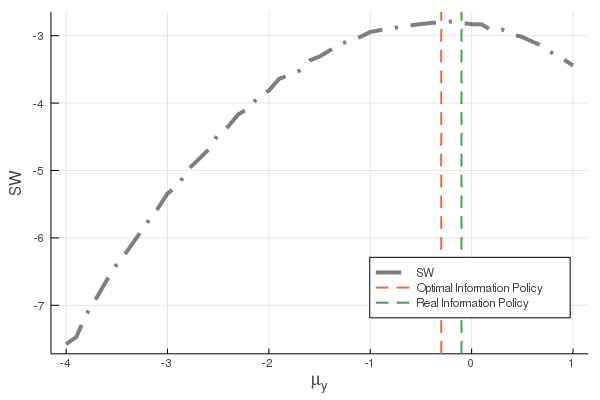

In [287]:
SW_est = [-7.576, -7.47, -7.133, -6.89, -6.63, -6.392, -6.2, -5.987, -5.773, -5.574, -5.342, -5.228, -4.988, -4.845, -4.6966, -4.464, -4.344, -4.1656, -4.08, -3.9, -3.814, -3.642, -3.58266, -3.52, -3.37, -3.31, -3.22, -3.122, -3.08, -3.02, -2.9453, -2.9174, -2.905, -2.8626, -2.8478, -2.828143, -2.812181, -2.8, -2.79, -2.81,-2.83, -2.833, -2.925, -2.91, -2.982, -3.02, -3.09, -3.152, -3.262, -3.344, -3.442]
g = (-4.0:0.1:1.0)
plot(g, SW_est, alpha = 0.5, c = :black, linewidth = 4, label = "SW", linestyle = :dashdot, xlab = "\\mu_y", ylab = "SW", legend = :bottomright)
vline!([-0.3 -0.1], linestyle = :dash, linewidth = 2, label = ["Optimal Information Policy" "Real Information Policy"])

## We can clerly see, that the information policy, which took place in practice was close to optimal for social welfare. Clearly, the real information policy of the Bank of Russis could slightly improve social welfare it it would be more biased!

See plots below to get the intuitioh of how key elements of the model behave given optimal information policy from the government.

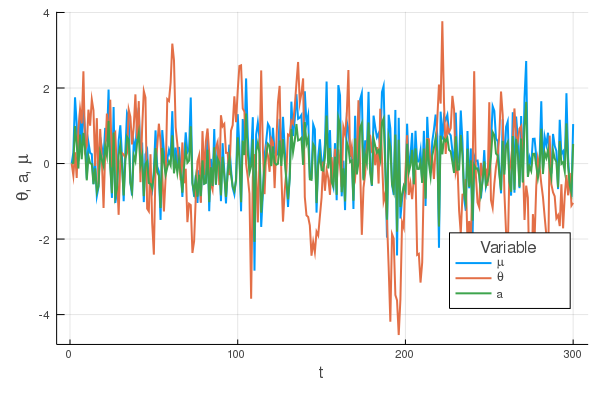

In [292]:
ps = plot(eachindex(df.μ), df.μ, lw = 2, label = "\\mu")
plot!(eachindex(df.θ), df.θ, lw = 2, label = "\\theta")
plot!(eachindex(df.a_i), df.a_i, lw = 2, label = "a")
plot!(xlabel = "t", ylabel = "\\theta, a, \\mu", legend_title = "Variable", legend = :bottomright)

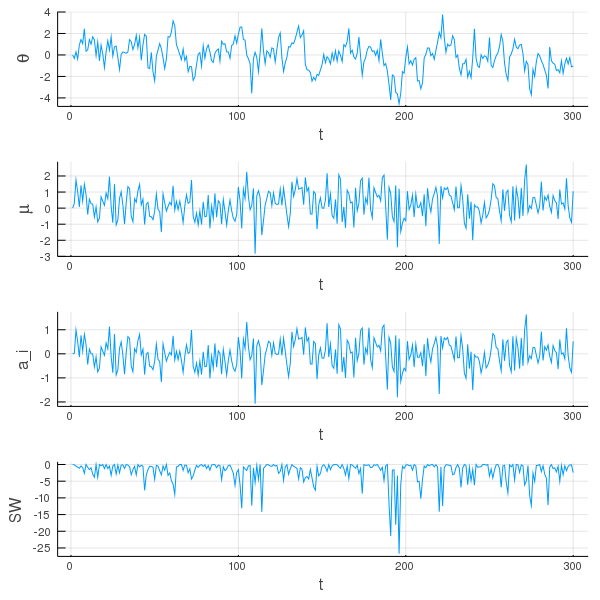

In [293]:
len = eachindex(df.θ)
yvals = [df.θ, df.μ, df.a_i, df.SW]
vars = ["\\theta", "\\mu", "a_i", "SW"]

plt = plot(layout = (4,1), size = (600, 600))

for i in 1:4
    plot!(plt[i], len, yvals[i], xlabel = "t", ylabel = vars[i], label = "")
end

pf = plot(plt)

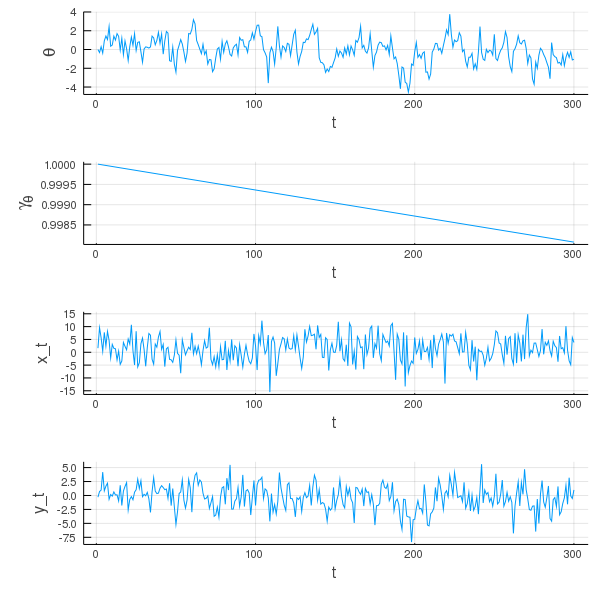

In [294]:
len = eachindex(df.θ)
yvals = [df.θ, df.β_1, df.x_t, df.y_t]
vars = ["\\theta", "\\gamma_\\theta", "x_t", "y_t"]

plt = plot(layout = (4,1), size = (600, 600))

for i in 1:4
    plot!(plt[i], len, yvals[i], xlabel = "t", ylabel = vars[i], label = "")
end

pff = plot(plt)